## 06 PCA visualization, logistic regression, random forests and neural network and conclusions

In this notebook we visualize the embeddings produced and classify the chunks using the different embeddings and three machine learning methods: logistic regression, random forests and (shallow) neural networks.

We discuss the performance, look at the confusion matrices, the different scores and some misclassified chunks, list some ways to improve the models and draw some lessons.

<i>The log reg/random forest cell takes about 90 minutes, the nn cell makes about 10 minutes on my computer.</i>

Let's load our data and the necessary packages. We load both the vectors created and the original chunks for the error analysis. We use the too_big.pkl file to take into account the couple of files that were dropped (because the chunks were too big for camembert) and the chunk_numbers files to identify which book each chunk comes from. (A csv file/pandas dataframe to store all this data would have been better choice.)

In [1]:

import time
import pandas as pd
import numpy as np
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1' #we supress the tensorflow info messages
from sklearn.utils import shuffle

emb_models=["w2v", 'fastText', "uni_sent_enc", "camembert-wiki", "camembert-large"]
vector_sizes=[200, 300, 512, 768, 1024]
import pickle

with open("too_big.pkl", "rb") as file:
    too_big = pickle.load(file)

In [2]:
X={}
y={}
size={}
all_data={}
X_train={}
y_={}
y_train={}
le={}
scaler={}
test_fold={}
X_train_preprocessed={}
X_test_preprocessed={}
shuffled_indeces={}
mapping_in_fold={}
y_train_numbers={}
y_test_numbers={}
import numpy as np
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
for m in emb_models:
    all_data[m]={}
    X[m]={}
    y[m]={}
    size[m]={}
    shuffled_indeces[m]={}
    mapping_in_fold[m]={}
    for t in ["valid1", "valid2", "valid3", "valid4", "test"]:
        with np.load(os.path.join( "embeddings", m+'_'+t+".npz"), allow_pickle=False) as npz_file:
            all_data[m][t] = dict(npz_file.items())
            X[m][t]=all_data[m][t]["X"]
            y[m][t]=all_data[m][t]["y"]
        
        
        size[m][t]=X[m][t].shape[0]
        X[m][t], y[m][t], shuffled_indeces[m][t] = shuffle(X[m][t], y[m][t], range(size[m][t]), random_state=0) #we shuffle the data within the folds
    
    test_fold[m]=[0]*size[m]["valid1"]+[1]*size[m]["valid2"]+[2]*size[m]["valid3"]+[3]*size[m]["valid4"] ##this will be used to define our splits according to the folds we created
    
    X_train[m] = np.vstack([X[m]["valid1"], X[m]["valid2"], X[m]["valid3"], X[m]["valid4"]])
    y_train[m] = np.hstack([y[m]["valid1"], y[m]["valid2"], y[m]["valid3"], y[m]["valid4"]])
    
    
    scaler[m] = StandardScaler()
    X_train_preprocessed[m] = scaler[m].fit_transform(X_train[m])
    X_test_preprocessed[m] = scaler[m].transform(X[m]["test"])



In [3]:
no_dupl=pd.read_csv('no_dupl.csv', index_col=0)
all_chunks={}
all_chunk_numbers_df={}
all_chunk_numbers={}
for t in ["valid1", "valid2", "valid3", "valid4", 'test']:
    all_chunks[t]=[]
    all_chunk_numbers[t]=[]
    all_chunk_numbers_df[t]=pd.read_csv(os.path.join(t, 'chunk_numbers.csv'), index_col=0)
    for author in no_dupl["author"].unique():
        with open(os.path.join(t, author), 'r') as f:
            not_too_big_chunks=[chunk for i, chunk in enumerate(f.read().split("\n\t\t\n")) if i not in too_big[t][author]]
            not_too_big_chunk_numbers=[number for i, number in enumerate(all_chunk_numbers_df[t][author].values) if i not in too_big[t][author]]
            all_chunks[t]+=not_too_big_chunks
            all_chunk_numbers[t]+=not_too_big_chunk_numbers
            

## PCA

We perform Principal componenent analysis, calculate the number of components to explain 10%, 20%, 90% of the variance and visualize the first 2 components.

In [4]:
from sklearn.preprocessing import StandardScaler

from sklearn.decomposition import PCA
explained_variance=pd.DataFrame()
pca={}
X_train_pca={}
pve={}
pve_cumsum={}
X_train_2d={}

for m in emb_models:

    pca[m] = PCA(n_components=None)
    X_train_pca[m] = pca[m].fit_transform(X_train_preprocessed[m])
    pve[m] = pca[m].explained_variance_ratio_
    pve_cumsum[m] = np.cumsum(pve[m])
    limit=.1
    for i, p in enumerate(pve_cumsum[m]):
        if p>limit and limit<=.9:
            #print('For embedding {}, the first {} component explains more than the {:.0f}% of the variance'.format(m, i+1, limit*100))
            explained_variance.loc['{:.0f}%'.format(limit*100), m]=i+1
            limit+=.1
    X_train_2d[m]=X_train_pca[m][:, :2]
print('Number of components needed to explain a given percentage of the variance:')
explained_variance

Number of components needed to explain a given percentage of the variance:


w2v  fastText  uni_sent_enc  camembert-wiki  camembert-large
10%   1.0       1.0           2.0             1.0              2.0
20%   2.0       2.0           5.0             2.0              4.0
30%   3.0       3.0          12.0             4.0              8.0
40%   4.0       4.0          22.0             6.0             13.0
50%   5.0       5.0          37.0             9.0             22.0
60%   6.0       6.0          55.0            15.0             36.0
70%   7.0      10.0          79.0            26.0             58.0
80%   8.0      16.0         110.0            48.0             96.0
90%  14.0      33.0         156.0            93.0            170.0

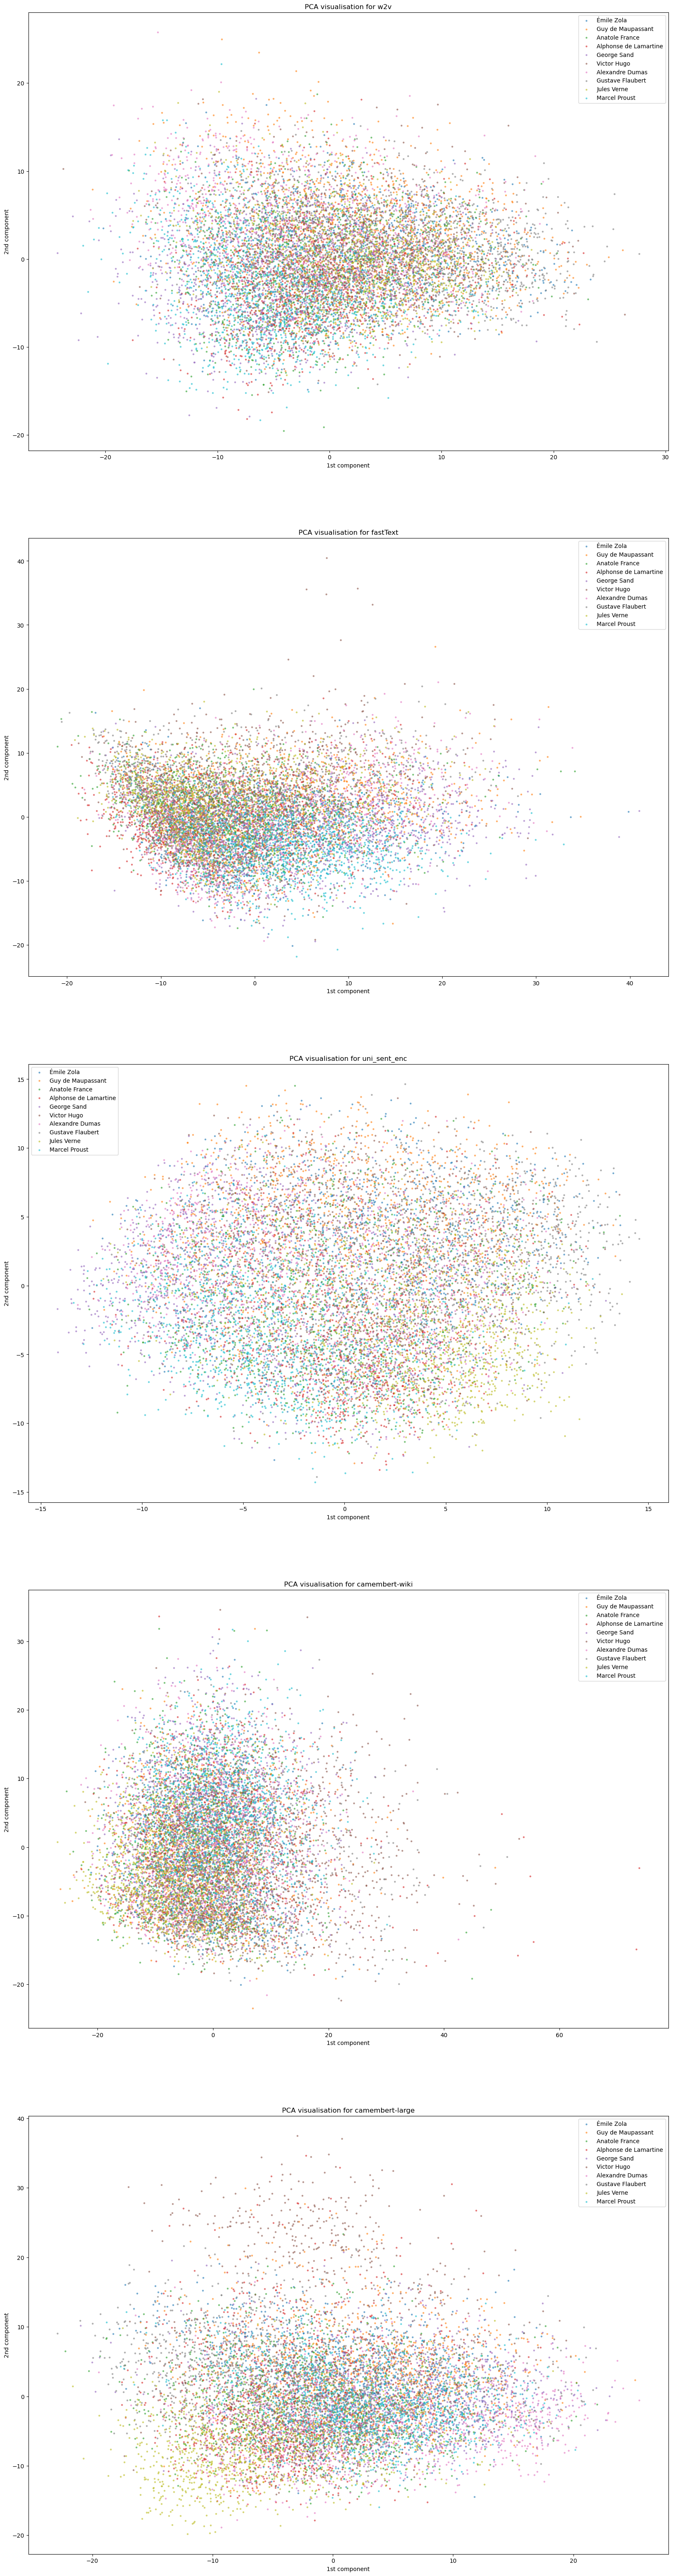

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
fig, axs = plt.subplots(5,1, figsize=(20, 80))
for i, m in enumerate(emb_models):
    for author in list(set(y_train[m])):
        idx =   [True if l == author else False for l in y_train[m]] 
        axs[i].scatter(
            X_train_2d[m][idx, 0], X_train_2d[m][idx, 1],
            label=author,
            alpha=.5,
            s=5
            )
    axs[i].set_xlabel('1st component')
    axs[i].set_ylabel('2nd component')
    axs[i].set_title('PCA visualisation for {}'.format(m))

    axs[i].legend()

plt.show()

While there are regions of these plots where one color dominates, there is no color that can is concentrated on one part of the graph: we cannot identify an author cluster in this two dimensional projection. The classification will probably be harder than in project 4.

## Logistic Regression and Random Forest

We now try the first two methods: logistic regression and random forests. For logistic regression we use grid search with cross validation, for random forest we use its randomized version as going through all the grid would be impractical. For logistic regression, we change the regularisation parameter C. For random forest, we change whether we use PCA and how much we reduce the dimensions, the maximum depth of the trees, the number of trees and the minimum number of samples that are required to be at a leaf node.

For logistic regression, we scale the data (for random forest, it would not change anything.)

As explained in earlier notebooks, we use predefined validation splits in the cross-validation.

In [6]:
from sklearn.linear_model import LogisticRegression

from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

from sklearn.model_selection import PredefinedSplit
from sklearn.model_selection import RandomizedSearchCV


In [7]:

results_df=pd.DataFrame()


logreg_estimator = Pipeline([
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression(solver='liblinear'))
])

rf_estimator = Pipeline([
    ('reduce_dim', PCA()),
    ('rf', RandomForestClassifier())
])


rf_grid = {
    'reduce_dim': ['passthrough', PCA(5), PCA(20), PCA(100)],
    'rf__max_depth': [5, 10, 30],
    'rf__n_estimators': [4, 256, 1024],
    'rf__min_samples_leaf': [1, 3, 5, 10]
}

logreg_grid = {
    'logreg__C': np.logspace(-4, 2, num=7),
}

logreg_gscv={}
logreg_results={}
rf_rscv={}
rf_results={}
print(time.ctime())
for m in emb_models:
    print("Embedding used: ", m, ". Logistic regression.")
    
    logreg_gscv[m] = GridSearchCV(logreg_estimator, logreg_grid, cv=PredefinedSplit(test_fold=test_fold[m]),
                                refit=True, return_train_score=True, n_jobs=-1, verbose=1)
    logreg_gscv[m].fit(X_train[m], y_train[m])
    logreg_results[m] = pd.DataFrame({
      'C': logreg_gscv[m].cv_results_['param_logreg__C'],
      'mean_tr': logreg_gscv[m].cv_results_['mean_train_score'],
      'mean_te': logreg_gscv[m].cv_results_['mean_test_score'],
      'std_te': logreg_gscv[m].cv_results_['std_test_score']
    })
    display(logreg_results[m].sort_values(by='mean_te', ascending=False))
    result=logreg_gscv[m].score(X[m]["test"], y[m]["test"])
    results_df.loc[m, "logreg"]=result
    print("Final test score for logistic regression for embedding {}: {}".format(m, result))
    print(time.ctime())  

    print("Embedding used: ", m, ". Random forest.")
    rf_rscv[m] = RandomizedSearchCV(rf_estimator, rf_grid, cv=PredefinedSplit(test_fold=test_fold[m]),
                            refit=True, return_train_score=True, n_jobs=-1, verbose=1, random_state=0)
    rf_rscv[m].fit(X_train[m], y_train[m])
    rf_results[m] = pd.DataFrame({
        'comp': rf_rscv[m].cv_results_['param_reduce_dim'],
        'depth': rf_rscv[m].cv_results_['param_rf__max_depth'],
        'tree_number': rf_rscv[m].cv_results_['param_rf__n_estimators'],
        'min_leaf': rf_rscv[m].cv_results_['param_rf__min_samples_leaf'],
        'mean_tr': rf_rscv[m].cv_results_['mean_train_score'],
        'mean_te': rf_rscv[m].cv_results_['mean_test_score'],
        'std_te': rf_rscv[m].cv_results_['std_test_score']
    })
    rf_results[m]['comp'] = rf_results[m]['comp'].apply(lambda x: x.n_components if x != 'passthrough' else x)
    display(rf_results[m].sort_values(by='mean_te', ascending=False))
    result=rf_rscv[m].score(X[m]["test"], y[m]["test"])
    results_df.loc[m, "random forests"]=result
    print("Final test score for random forest, for embedding {}: {}".format(m, result))
    print(time.ctime())


Sun Apr  2 21:04:49 2023
Embedding used:  w2v . Logistic regression.
Fitting 4 folds for each of 7 candidates, totalling 28 fits


C   mean_tr   mean_te    std_te
6   100.0  0.644410  0.497038  0.013393
5    10.0  0.611736  0.487871  0.014631
4     1.0  0.559862  0.463700  0.021535
3     0.1  0.514545  0.439861  0.017764
2    0.01  0.478508  0.411021  0.019402
1   0.001  0.439499  0.384766  0.019978
0  0.0001  0.388819  0.342837  0.024972

Final test score for logistic regression for embedding w2v: 0.46110183639399
Sun Apr  2 21:13:11 2023
Embedding used:  w2v . Random forest.
Fitting 4 folds for each of 10 candidates, totalling 40 fits


comp depth tree_number min_leaf   mean_tr   mean_te    std_te
5          100    10        1024        5  0.921870  0.386765  0.021275
3  passthrough    30        1024        1  1.000000  0.353755  0.028761
9  passthrough    10         256        3  0.806091  0.346587  0.031050
7  passthrough    10         256       10  0.675364  0.345505  0.031193
4          100     5        1024        1  0.485817  0.343583  0.026114
1           20    10        1024        3  0.795728  0.339752  0.023353
2           20    30         256        1  1.000000  0.338920  0.022122
0  passthrough     5         256        5  0.408074  0.312328  0.030034
6            5    10        1024       10  0.472841  0.248312  0.022501
8          100    10           4       10  0.488594  0.235145  0.013705

Final test score for random forest, for embedding w2v: 0.35358931552587647
Sun Apr  2 21:17:48 2023
Embedding used:  fastText . Logistic regression.
Fitting 4 folds for each of 7 candidates, totalling 28 fits


C   mean_tr   mean_te    std_te
4     1.0  0.848211  0.661910  0.023958
3     0.1  0.826039  0.660659  0.024992
5    10.0  0.853546  0.651658  0.023066
6   100.0  0.854657  0.643906  0.024745
2    0.01  0.763357  0.630654  0.024426
1   0.001  0.669500  0.565637  0.023512
0  0.0001  0.550359  0.471783  0.030759

Final test score for logistic regression for embedding fastText: 0.6106844741235392
Sun Apr  2 21:22:35 2023
Embedding used:  fastText . Random forest.
Fitting 4 folds for each of 10 candidates, totalling 40 fits


comp depth tree_number min_leaf   mean_tr   mean_te    std_te
5          100    10        1024        5  0.948015  0.488205  0.028384
3  passthrough    30        1024        1  1.000000  0.461701  0.024855
7  passthrough    10         256       10  0.793170  0.437778  0.025491
9  passthrough    10         256        3  0.904281  0.437361  0.023221
4          100     5        1024        1  0.576144  0.424189  0.032864
2           20    30         256        1  1.000000  0.423773  0.023617
1           20    10        1024        3  0.829096  0.415355  0.022155
0  passthrough     5         256        5  0.493818  0.380016  0.029968
8          100    10           4       10  0.561752  0.296154  0.017727
6            5    10        1024       10  0.486705  0.287158  0.023100

Final test score for random forest, for embedding fastText: 0.4420701168614357
Sun Apr  2 21:27:27 2023
Embedding used:  uni_sent_enc . Logistic regression.
Fitting 4 folds for each of 7 candidates, totalling 28 fits


C   mean_tr   mean_te    std_te
2    0.01  0.708676  0.517791  0.017798
3     0.1  0.744713  0.506704  0.016963
1   0.001  0.651967  0.502955  0.018081
4     1.0  0.756771  0.491533  0.016451
5    10.0  0.760577  0.484781  0.017536
6   100.0  0.761911  0.481696  0.020026
0  0.0001  0.578977  0.465281  0.014098

Final test score for logistic regression for embedding uni_sent_enc: 0.4801335559265442
Sun Apr  2 21:35:00 2023
Embedding used:  uni_sent_enc . Random forest.
Fitting 4 folds for each of 10 candidates, totalling 40 fits


comp depth tree_number min_leaf   mean_tr   mean_te    std_te
3  passthrough    30        1024        1  1.000000  0.434190  0.020324
7  passthrough    10         256       10  0.835487  0.414768  0.019109
9  passthrough    10         256        3  0.946487  0.414184  0.020112
5          100    10        1024        5  0.896724  0.407849  0.024150
2           20    30         256        1  1.000000  0.397680  0.020346
1           20    10        1024        3  0.794866  0.388846  0.023621
0  passthrough     5         256        5  0.507598  0.372008  0.021521
4          100     5        1024        1  0.531826  0.371507  0.022546
6            5    10        1024       10  0.512350  0.318746  0.018666
8          100    10           4       10  0.524852  0.277237  0.013862

Final test score for random forest, for embedding uni_sent_enc: 0.410016694490818
Sun Apr  2 21:43:02 2023
Embedding used:  camembert-wiki . Logistic regression.
Fitting 4 folds for each of 7 candidates, totalling 28 fits


C   mean_tr   mean_te    std_te
3     0.1  0.889082  0.672576  0.026108
4     1.0  0.926397  0.667491  0.028915
2    0.01  0.838653  0.664576  0.028401
5    10.0  0.952765  0.647736  0.030824
1   0.001  0.774748  0.629735  0.023633
6   100.0  0.969686  0.622312  0.031166
0  0.0001  0.674140  0.564304  0.031490

Final test score for logistic regression for embedding camembert-wiki: 0.6554257095158598
Sun Apr  2 22:06:26 2023
Embedding used:  camembert-wiki . Random forest.
Fitting 4 folds for each of 10 candidates, totalling 40 fits


comp depth tree_number min_leaf   mean_tr   mean_te    std_te
3  passthrough    30        1024        1  1.000000  0.501539  0.042173
7  passthrough    10         256       10  0.885750  0.484033  0.041967
9  passthrough    10         256        3  0.962324  0.478700  0.040492
5          100    10        1024        5  0.947209  0.473700  0.031215
2           20    30         256        1  1.000000  0.441443  0.026060
1           20    10        1024        3  0.838211  0.433025  0.027815
4          100     5        1024        1  0.579895  0.422271  0.031617
0  passthrough     5         256        5  0.566420  0.415434  0.043934
8          100    10           4       10  0.571171  0.285735  0.019021
6            5    10        1024       10  0.459671  0.240889  0.026567

Final test score for random forest, for embedding camembert-wiki: 0.47545909849749585
Sun Apr  2 22:15:45 2023
Embedding used:  camembert-large . Logistic regression.
Fitting 4 folds for each of 7 candidates, totalling 28 fits


C   mean_tr   mean_te    std_te
3     0.1  0.968658  0.735675  0.022967
2    0.01  0.930843  0.728924  0.022743
4     1.0  0.994415  0.718754  0.024754
5    10.0  0.999833  0.699000  0.022290
6   100.0  1.000000  0.689582  0.020071
1   0.001  0.869022  0.686915  0.021581
0  0.0001  0.767747  0.610149  0.023672

Final test score for logistic regression for embedding camembert-large: 0.6881469115191987
Sun Apr  2 22:33:26 2023
Embedding used:  camembert-large . Random forest.
Fitting 4 folds for each of 10 candidates, totalling 40 fits


comp depth tree_number min_leaf   mean_tr   mean_te    std_te
3  passthrough    30        1024        1  1.000000  0.570471  0.027423
9  passthrough    10         256        3  0.970104  0.551717  0.027750
7  passthrough    10         256       10  0.921064  0.547717  0.027838
5          100    10        1024        5  0.927176  0.531877  0.026469
2           20    30         256        1  1.000000  0.517957  0.021156
1           20    10        1024        3  0.832374  0.503203  0.023560
0  passthrough     5         256        5  0.676641  0.498037  0.033004
4          100     5        1024        1  0.650969  0.476531  0.022949
6            5    10        1024       10  0.570086  0.386256  0.031938
8          100    10           4       10  0.641881  0.365258  0.008513

Final test score for random forest, for embedding camembert-large: 0.5318864774624374
Sun Apr  2 22:44:53 2023


We will analyse the results in the Analysis of accuracy section, after training the neural networks.

## Neural network

Now we try to classify the chunks with a neural network. It has a very simple architecture: it consist of an input layer, some optional dense layers, a dropout layer and an output layer. In our randomized grid search, we change the number of layers, the number of units in the hidden layers, the dropout rate and the value of the l2 regularization penalty. We also scale the data here.


In [8]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import activations
from tensorflow.keras import initializers
from tensorflow.keras import losses
from tensorflow.keras import metrics
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout

In [9]:

def create_model(dropout_factor=.2, reg=.01, n=64, depth=2):
    model = Sequential() #model inspired from https://medium.com/voice-tech-podcast/text-classification-using-cnn-9ade8155dfb9
    model.add(Dense(
    units=n, activation=activations.relu, input_dim=vect_size,
    kernel_initializer=initializers.VarianceScaling(scale=1.0, seed=0),
    kernel_regularizer=tf.keras.regularizers.l2(reg)))
    if depth>3:
        for i in range(depth-3):
            model.add(Dense(
            units=n, activation=activations.softmax,
            kernel_initializer=initializers.VarianceScaling(scale=1.0, seed=0),
            kernel_regularizer=tf.keras.regularizers.l2(reg)
            ))
    model.add(Dropout(dropout_factor))
    model.add(Dense(
        units=10, activation=activations.softmax,
        kernel_initializer=initializers.VarianceScaling(scale=1.0, seed=0),
        kernel_regularizer=tf.keras.regularizers.l2(reg)
        ))
    model.compile(optimizer=Adam(learning_rate=0.01), loss='sparse_categorical_crossentropy', metrics=['acc'])
    return model

In [10]:
import time
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import  RandomizedSearchCV
from sklearn.model_selection import PredefinedSplit

nn_grid = {
    'dropout_factor':[0.1, 0.3],
    'reg':np.logspace(-6, -2, num=5),
    'n':[64, 256, 512],
    'depth':[ 3, 4, 5]
    }

classifier = KerasClassifier(model=create_model, dropout_factor=0.1, reg=0.0001, n=64, depth=2, epochs=20, verbose=0, batch_size = 128)


nn_rscv={}
nn_results={}
print(time.ctime())
for j, m in enumerate(emb_models):
    print('Embedding used: {}:'.format(m))
    
    vect_size = vector_sizes[j]
    nn_rscv[m] = RandomizedSearchCV(classifier, param_distributions=nn_grid,  n_jobs=-1, 
                                    cv=PredefinedSplit(test_fold=test_fold[m]), return_train_score=True, random_state=0)
    nn_rscv[m].fit(X_train_preprocessed[m], y_train[m])
    nn_results[m] = pd.DataFrame({
      'dropout': nn_rscv[m].cv_results_['param_dropout_factor'],
      'l2 reg': nn_rscv[m].cv_results_['param_reg'],
      'units': nn_rscv[m].cv_results_['param_n'],
      'depth': nn_rscv[m].cv_results_['param_depth'],
      'mean_tr': nn_rscv[m].cv_results_['mean_train_score'], 
      'mean_te': nn_rscv[m].cv_results_['mean_test_score'],
      'std_te': nn_rscv[m].cv_results_['std_test_score']
    })
    display(nn_results[m].sort_values(by='mean_te', ascending=False))
    result=nn_rscv[m].score(X_test_preprocessed[m], y[m]['test'])
    results_df.loc[m, "neural network"]=result
    print("Final test score for neural network, for embedding {}: {}".format(m, result))
    print(time.ctime())
results_df.to_csv('results_df.csv', index=False)  

Sun Apr  2 22:44:59 2023
Embedding used: w2v:


dropout    l2 reg units depth   mean_tr   mean_te    std_te
0     0.1    0.0001    64     3  0.519463  0.402850  0.026420
1     0.1     0.001   512     3  0.464421  0.380099  0.019931
6     0.3  0.000001    64     4  0.371203  0.313580  0.025238
5     0.1  0.000001    64     4  0.381762  0.305831  0.011075
2     0.3     0.001   256     4  0.324219  0.284581  0.038976
7     0.1     0.001   512     4  0.245221  0.222071  0.073421
3     0.1   0.00001   512     4  0.222667  0.204293  0.044091
4     0.1   0.00001   256     5  0.118087  0.105525  0.009900
8     0.3     0.001    64     5  0.100025  0.100025  0.000043
9     0.3      0.01   512     5  0.099997  0.100025  0.000043

Final test score for neural network, for embedding w2v: 0.38263772954924874
Sun Apr  2 22:47:18 2023
Embedding used: fastText:


dropout    l2 reg units depth   mean_tr   mean_te    std_te
0     0.1    0.0001    64     3  0.860797  0.623316  0.032868
1     0.1     0.001   512     3  0.749158  0.572892  0.010903
5     0.1  0.000001    64     4  0.650221  0.517037  0.049866
6     0.3  0.000001    64     4  0.626292  0.513795  0.034388
2     0.3     0.001   256     4  0.469148  0.397505  0.037077
7     0.1     0.001   512     4  0.447664  0.389016  0.010583
3     0.1   0.00001   512     4  0.296515  0.266656  0.018411
4     0.1   0.00001   256     5  0.174487  0.170630  0.041131
8     0.3     0.001    64     5  0.099969  0.100025  0.000043
9     0.3      0.01   512     5  0.100025  0.100025  0.000043

Final test score for neural network, for embedding fastText: 0.5669449081803005
Sun Apr  2 22:49:47 2023
Embedding used: uni_sent_enc:


dropout    l2 reg units depth   mean_tr   mean_te    std_te
0     0.1    0.0001    64     3  0.930621  0.471445  0.017394
1     0.1     0.001   512     3  0.821732  0.460028  0.013766
5     0.1  0.000001    64     4  0.608481  0.422279  0.016424
6     0.3  0.000001    64     4  0.576391  0.420686  0.034791
2     0.3     0.001   256     4  0.460473  0.367761  0.015521
3     0.1   0.00001   512     4  0.353448  0.287908  0.009006
4     0.1   0.00001   256     5  0.100025  0.100025  0.000043
9     0.3      0.01   512     5  0.100025  0.100025  0.000043
7     0.1     0.001   512     4  0.099997  0.099942  0.000101
8     0.3     0.001    64     5  0.099942  0.099942  0.000101

Final test score for neural network, for embedding uni_sent_enc: 0.41669449081803006
Sun Apr  2 22:52:47 2023
Embedding used: camembert-wiki:


dropout    l2 reg units depth   mean_tr   mean_te    std_te
0     0.1    0.0001    64     3  0.913922  0.602563  0.019403
1     0.1     0.001   512     3  0.795837  0.579720  0.033285
5     0.1  0.000001    64     4  0.597619  0.494781  0.027240
6     0.3  0.000001    64     4  0.547493  0.444697  0.017184
2     0.3     0.001   256     4  0.483396  0.421271  0.026235
7     0.1     0.001   512     4  0.341184  0.287599  0.113782
3     0.1   0.00001   512     4  0.258284  0.225986  0.043606
4     0.1   0.00001   256     5  0.125867  0.123358  0.040400
8     0.3     0.001    64     5  0.099969  0.100025  0.000043
9     0.3      0.01   512     5  0.100025  0.100025  0.000043

Final test score for neural network, for embedding camembert-wiki: 0.5706176961602671
Sun Apr  2 22:56:30 2023
Embedding used: camembert-large:


dropout    l2 reg units depth   mean_tr   mean_te    std_te
0     0.1    0.0001    64     3  0.962823  0.660246  0.032812
1     0.1     0.001   512     3  0.900029  0.642740  0.011879
6     0.3  0.000001    64     4  0.726070  0.572132  0.043954
5     0.1  0.000001    64     4  0.739965  0.559957  0.037960
2     0.3     0.001   256     4  0.512017  0.409680  0.022573
3     0.1   0.00001   512     4  0.375616  0.313095  0.044486
7     0.1     0.001   512     4  0.358972  0.311442  0.122777
4     0.1   0.00001   256     5  0.099969  0.100025  0.000043
8     0.3     0.001    64     5  0.100025  0.100025  0.000043
9     0.3      0.01   512     5  0.100025  0.100025  0.000043

Final test score for neural network, for embedding camembert-large: 0.5939899833055092
Sun Apr  2 23:00:59 2023


## Analysis of accuracy

Let's have a look at our test results, the accuracy of our models, and visualize them.

In [11]:
results_df

logreg  random forests  neural network
w2v              0.461102        0.353589        0.382638
fastText         0.610684        0.442070        0.566945
uni_sent_enc     0.480134        0.410017        0.416694
camembert-wiki   0.655426        0.475459        0.570618
camembert-large  0.688147        0.531886        0.593990

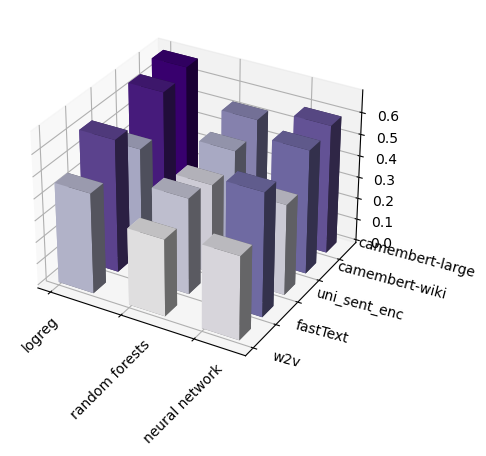

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import colormaps
def threed_bar(df):
    x = np.arange(len(df.columns))
    y = np.arange(len(df.index))
    z = df.values

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    xpos, ypos = np.meshgrid(x, y)
    xpos = xpos.flatten()
    ypos = ypos.flatten()
    zpos = np.zeros_like(xpos)
    dx = .5*np.ones_like(zpos)
    dy = .5*np.ones_like(zpos)
    dz = z.flatten()

    colormap =colormaps['Purples']
    norm = plt.Normalize(dz.min(), dz.max())
    ax.bar3d(xpos, ypos, zpos, dx, dy, dz, shade = True, color = colormap(norm(dz)))
    ax.set_xticks(x)
    ax.set_yticks(y)


    ax.set_xticklabels(list(results_df.columns), rotation=45, 
                       position=(-20, 20))
    ax.set_yticklabels(list(results_df.index),  rotation=-15, 
                       horizontalalignment='left', 
                       verticalalignment='baseline', 
                       position=(-20, 20)
                      )

    plt.show()
threed_bar(results_df)

Logistic regression works better then our shallow network which in turn works better than random forest.
In general, larger embeddings (in terms of model size and dimension) work better than smaller ones, except the universal sentence encoder.
This might be because it is multilingual and not French-specific. All our method-embedding pairs beat random guessing (which would be 10%) by a large margin.

The two camembert embeddings, however, have significant resource requirements both at the training and at inference (the latter of which we abstracted away by calculating the embeddings for the training and test sets together). If these resource costs matter, it may be a better idea to choose spacy fastText which has much lower resource requirements.

We also have to consider that the better performance of camembert-large is explained not only by the fact that is is big, but also that it was trained on CCNet which includes the Gutenberg Project. This may also be the case for fastText and the universal sentence encoder (I had some trouble finding what corpus they were trained on). This somewhat undermines the generalizability of our models to a "new manuscript".

### Validation curves


Despite regularisation in the logistic regression and neural network and trying different min_samples_leaf and max_depth parameters, most of our well-performing models overfit, as can be seen in these train and validation score curves for logistic regression:

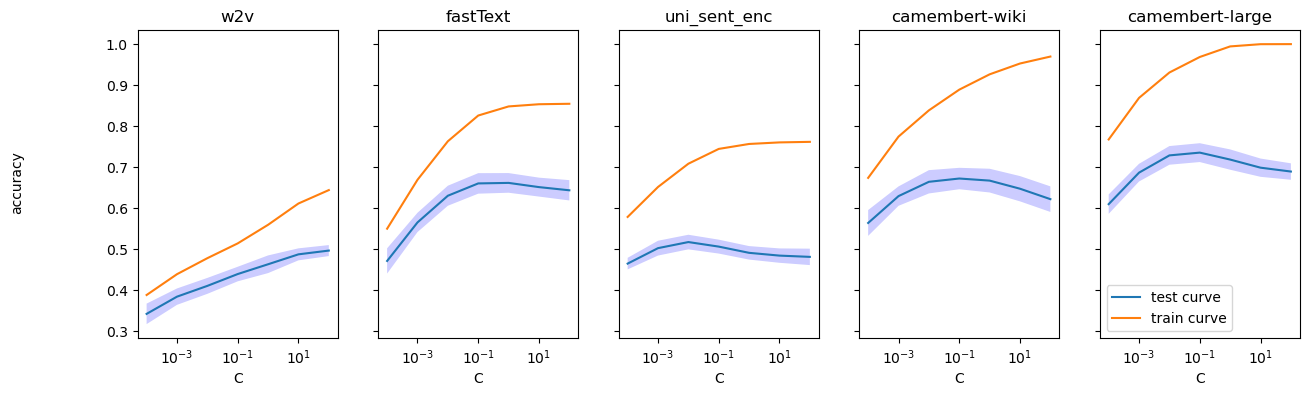

In [13]:

%matplotlib inline
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, len(emb_models), sharey=True,  figsize=(15, 4))
for i, m in enumerate(emb_models):
    axs[i].semilogx(logreg_results[m]['C'], logreg_results[m]['mean_te'], label='test curve')

    axs[i].fill_between(logreg_results[m]['C'].astype('float'),
                 logreg_results[m]['mean_te']+logreg_results[m]['std_te'],
                 logreg_results[m]['mean_te']-logreg_results[m]['std_te'], 
                 facecolor='blue', alpha=0.2)
    
    axs[i].semilogx(logreg_results[m]['C'], logreg_results[m]['mean_tr'], label='train curve')
    axs[i].set_title(m)
    axs[i].set_xlabel('C')
fig.text(0.04, 0.5, 'accuracy', va='center', rotation='vertical')
plt.legend()
plt.show()

However, the low standard deviation of the validations scores across validation splits and the care with which which we constructed our validation splits can give us confidence about the generalization performance of our classification models which is further corroborated by the final test scores, which are not that far from the validation scores (they are somewhat lower in most cases but it is understandable because of the exception we had to make for Proust when we created the bundles.)

### Classification report and confusion matrix

Let's create confusion matrices for all our embeddings and methods. Furthermore, let's generate a classification report for all embedding-method pair.

In [14]:
best_emb = 'camembert-large'
best_model={}
for emb in emb_models:
    best_model[emb]={}
    best_model[emb]['logreg'] = logreg_gscv[emb].best_estimator_
    best_model[emb]['rf'] = rf_rscv[emb].best_estimator_
    best_model[emb]['nn'] = nn_rscv[emb].best_estimator_

Accuracy for w2v and logreg: 0.46110183639399
Further scores for w2v and logreg:


precision    recall  f1-score  support
Alexandre Dumas         0.458333  0.513333  0.484277    300.0
Alphonse de Lamartine   0.398860  0.466667  0.430108    300.0
Anatole France          0.421277  0.330000  0.370093    300.0
George Sand             0.382090  0.426667  0.403150    300.0
Gustave Flaubert        0.513158  0.390000  0.443182    300.0
Guy de Maupassant       0.398907  0.486667  0.438438    300.0
Jules Verne             0.648876  0.770000  0.704268    300.0
Marcel Proust           0.487069  0.377926  0.425612    299.0
Victor Hugo             0.364407  0.290541  0.323308    296.0
Émile Zola              0.521875  0.556667  0.538710    300.0
macro avg               0.459485  0.460847  0.456115   2995.0
weighted avg            0.459603  0.461102  0.456302   2995.0

Accuracy for w2v and rf: 0.35358931552587647
Further scores for w2v and rf:


precision    recall  f1-score  support
Alexandre Dumas         0.360313  0.460000  0.404100    300.0
Alphonse de Lamartine   0.456853  0.300000  0.362173    300.0
Anatole France          0.357724  0.293333  0.322344    300.0
George Sand             0.301038  0.290000  0.295416    300.0
Gustave Flaubert        0.295720  0.253333  0.272890    300.0
Guy de Maupassant       0.296820  0.280000  0.288165    300.0
Jules Verne             0.461874  0.706667  0.558630    300.0
Marcel Proust           0.287469  0.391304  0.331445    299.0
Victor Hugo             0.280172  0.219595  0.246212    296.0
Émile Zola              0.421488  0.340000  0.376384    300.0
macro avg               0.351947  0.353423  0.345776   2995.0
weighted avg            0.352064  0.353589  0.345914   2995.0

Accuracy for w2v and nn: 0.38263772954924874
Further scores for w2v and nn:


precision    recall  f1-score  support
Alexandre Dumas         0.466258  0.506667  0.485623    300.0
Alphonse de Lamartine   0.332344  0.373333  0.351648    300.0
Anatole France          0.333333  0.290000  0.310160    300.0
George Sand             0.321705  0.276667  0.297491    300.0
Gustave Flaubert        0.380597  0.340000  0.359155    300.0
Guy de Maupassant       0.303977  0.356667  0.328221    300.0
Jules Verne             0.544944  0.646667  0.591463    300.0
Marcel Proust           0.340237  0.384615  0.361068    299.0
Victor Hugo             0.369318  0.219595  0.275424    296.0
Émile Zola              0.399381  0.430000  0.414125    300.0
macro avg               0.379209  0.382421  0.377438   2995.0
weighted avg            0.379236  0.382638  0.377580   2995.0

Accuracy for fastText and logreg: 0.6106844741235392
Further scores for fastText and logreg:


precision    recall  f1-score  support
Alexandre Dumas         0.577904  0.680000  0.624809    300.0
Alphonse de Lamartine   0.467822  0.630000  0.536932    300.0
Anatole France          0.532075  0.470000  0.499115    300.0
George Sand             0.474432  0.556667  0.512270    300.0
Gustave Flaubert        0.752443  0.770000  0.761120    300.0
Guy de Maupassant       0.655063  0.690000  0.672078    300.0
Jules Verne             0.787234  0.863333  0.823529    300.0
Marcel Proust           0.762590  0.354515  0.484018    299.0
Victor Hugo             0.416185  0.243243  0.307036    296.0
Émile Zola              0.708683  0.843333  0.770167    300.0
macro avg               0.613443  0.610109  0.599107   2995.0
weighted avg            0.613657  0.610684  0.599536   2995.0

Accuracy for fastText and rf: 0.4420701168614357
Further scores for fastText and rf:


precision    recall  f1-score  support
Alexandre Dumas         0.468023  0.536667  0.500000    300.0
Alphonse de Lamartine   0.345088  0.456667  0.393113    300.0
Anatole France          0.385417  0.246667  0.300813    300.0
George Sand             0.460606  0.506667  0.482540    300.0
Gustave Flaubert        0.439863  0.426667  0.433164    300.0
Guy de Maupassant       0.438944  0.443333  0.441128    300.0
Jules Verne             0.581602  0.653333  0.615385    300.0
Marcel Proust           0.322034  0.317726  0.319865    299.0
Victor Hugo             0.316129  0.165541  0.217295    296.0
Émile Zola              0.566952  0.663333  0.611367    300.0
macro avg               0.432466  0.441660  0.431467   2995.0
weighted avg            0.432658  0.442070  0.431790   2995.0

Accuracy for fastText and nn: 0.5669449081803005
Further scores for fastText and nn:


precision    recall  f1-score  support
Alexandre Dumas         0.571006  0.643333  0.605016    300.0
Alphonse de Lamartine   0.471939  0.616667  0.534682    300.0
Anatole France          0.527076  0.486667  0.506066    300.0
George Sand             0.466851  0.563333  0.510574    300.0
Gustave Flaubert        0.584615  0.506667  0.542857    300.0
Guy de Maupassant       0.539241  0.710000  0.612950    300.0
Jules Verne             0.806667  0.806667  0.806667    300.0
Marcel Proust           0.730263  0.371237  0.492239    299.0
Victor Hugo             0.358491  0.192568  0.250549    296.0
Émile Zola              0.638889  0.766667  0.696970    300.0
macro avg               0.569504  0.566381  0.555857   2995.0
weighted avg            0.569732  0.566945  0.556286   2995.0

Accuracy for uni_sent_enc and logreg: 0.4801335559265442
Further scores for uni_sent_enc and logreg:


precision    recall  f1-score  support
Alexandre Dumas         0.458065  0.473333  0.465574    300.0
Alphonse de Lamartine   0.443213  0.533333  0.484115    300.0
Anatole France          0.432950  0.376667  0.402852    300.0
George Sand             0.410774  0.406667  0.408710    300.0
Gustave Flaubert        0.440476  0.370000  0.402174    300.0
Guy de Maupassant       0.523179  0.526667  0.524917    300.0
Jules Verne             0.684211  0.866667  0.764706    300.0
Marcel Proust           0.494898  0.324415  0.391919    299.0
Victor Hugo             0.325000  0.263514  0.291045    296.0
Émile Zola              0.497475  0.656667  0.566092    300.0
macro avg               0.471024  0.479793  0.470210   2995.0
weighted avg            0.471211  0.480134  0.470476   2995.0

Accuracy for uni_sent_enc and rf: 0.410016694490818
Further scores for uni_sent_enc and rf:


precision    recall  f1-score  support
Alexandre Dumas         0.435986  0.420000  0.427844    300.0
Alphonse de Lamartine   0.345154  0.486667  0.403873    300.0
Anatole France          0.357447  0.280000  0.314019    300.0
George Sand             0.409222  0.473333  0.438949    300.0
Gustave Flaubert        0.405556  0.243333  0.304167    300.0
Guy de Maupassant       0.429078  0.403333  0.415808    300.0
Jules Verne             0.578164  0.776667  0.662873    300.0
Marcel Proust           0.275862  0.267559  0.271647    299.0
Victor Hugo             0.369231  0.243243  0.293279    296.0
Émile Zola              0.430199  0.503333  0.463902    300.0
macro avg               0.403590  0.409747  0.399636   2995.0
weighted avg            0.403678  0.410017  0.399821   2995.0

Accuracy for uni_sent_enc and nn: 0.41669449081803006
Further scores for uni_sent_enc and nn:


precision    recall  f1-score  support
Alexandre Dumas         0.463415  0.443333  0.453152    300.0
Alphonse de Lamartine   0.364238  0.366667  0.365449    300.0
Anatole France          0.279245  0.246667  0.261947    300.0
George Sand             0.338422  0.443333  0.383838    300.0
Gustave Flaubert        0.439024  0.300000  0.356436    300.0
Guy de Maupassant       0.450000  0.420000  0.434483    300.0
Jules Verne             0.694864  0.766667  0.729002    300.0
Marcel Proust           0.525862  0.204013  0.293976    299.0
Victor Hugo             0.296970  0.331081  0.313099    296.0
Émile Zola              0.397119  0.643333  0.491094    300.0
macro avg               0.424916  0.416509  0.408247   2995.0
weighted avg            0.425053  0.416694  0.408413   2995.0

Accuracy for camembert-wiki and logreg: 0.6554257095158598
Further scores for camembert-wiki and logreg:


precision    recall  f1-score  support
Alexandre Dumas         0.670695  0.740000  0.703645    300.0
Alphonse de Lamartine   0.507614  0.666667  0.576369    300.0
Anatole France          0.582192  0.566667  0.574324    300.0
George Sand             0.561224  0.550000  0.555556    300.0
Gustave Flaubert        0.763514  0.753333  0.758389    300.0
Guy de Maupassant       0.690789  0.700000  0.695364    300.0
Jules Verne             0.804533  0.946667  0.869832    300.0
Marcel Proust           0.780488  0.428094  0.552916    299.0
Victor Hugo             0.470968  0.246622  0.323725    296.0
Émile Zola              0.691748  0.950000  0.800562    300.0
macro avg               0.652376  0.654805  0.641068   2995.0
weighted avg            0.652576  0.655426  0.641521   2995.0

Accuracy for camembert-wiki and rf: 0.47545909849749585
Further scores for camembert-wiki and rf:


precision    recall  f1-score  support
Alexandre Dumas         0.456464  0.576667  0.509573    300.0
Alphonse de Lamartine   0.418367  0.546667  0.473988    300.0
Anatole France          0.527076  0.486667  0.506066    300.0
George Sand             0.463235  0.420000  0.440559    300.0
Gustave Flaubert        0.476987  0.380000  0.423006    300.0
Guy de Maupassant       0.511719  0.436667  0.471223    300.0
Jules Verne             0.565333  0.706667  0.628148    300.0
Marcel Proust           0.391489  0.307692  0.344569    299.0
Victor Hugo             0.237500  0.128378  0.166667    296.0
Émile Zola              0.556098  0.760000  0.642254    300.0
macro avg               0.460427  0.474940  0.460605   2995.0
weighted avg            0.460748  0.475459  0.461037   2995.0

Accuracy for camembert-wiki and nn: 0.5706176961602671
Further scores for camembert-wiki and nn:


precision    recall  f1-score  support
Alexandre Dumas         0.451550  0.776667  0.571078    300.0
Alphonse de Lamartine   0.521311  0.530000  0.525620    300.0
Anatole France          0.474138  0.550000  0.509259    300.0
George Sand             0.468165  0.416667  0.440917    300.0
Gustave Flaubert        0.649068  0.696667  0.672026    300.0
Guy de Maupassant       0.583871  0.603333  0.593443    300.0
Jules Verne             0.755102  0.863333  0.805599    300.0
Marcel Proust           0.777778  0.280936  0.412776    299.0
Victor Hugo             0.396341  0.219595  0.282609    296.0
Émile Zola              0.733974  0.763333  0.748366    300.0
macro avg               0.581130  0.570053  0.556169   2995.0
weighted avg            0.581311  0.570618  0.556583   2995.0

Accuracy for camembert-large and logreg: 0.6881469115191987
Further scores for camembert-large and logreg:


precision    recall  f1-score  support
Alexandre Dumas         0.694362  0.780000  0.734694    300.0
Alphonse de Lamartine   0.516630  0.776667  0.620506    300.0
Anatole France          0.657371  0.550000  0.598911    300.0
George Sand             0.556250  0.593333  0.574194    300.0
Gustave Flaubert        0.780303  0.686667  0.730496    300.0
Guy de Maupassant       0.731778  0.836667  0.780715    300.0
Jules Verne             0.849558  0.960000  0.901408    300.0
Marcel Proust           0.901961  0.461538  0.610619    299.0
Victor Hugo             0.506098  0.280405  0.360870    296.0
Émile Zola              0.764075  0.950000  0.846954    300.0
macro avg               0.695838  0.687528  0.675937   2995.0
weighted avg            0.696023  0.688147  0.676379   2995.0

Accuracy for camembert-large and rf: 0.5318864774624374
Further scores for camembert-large and rf:


precision    recall  f1-score  support
Alexandre Dumas         0.500000  0.593333  0.542683    300.0
Alphonse de Lamartine   0.422414  0.653333  0.513089    300.0
Anatole France          0.581673  0.486667  0.529946    300.0
George Sand             0.505051  0.500000  0.502513    300.0
Gustave Flaubert        0.531792  0.306667  0.389006    300.0
Guy de Maupassant       0.424749  0.423333  0.424040    300.0
Jules Verne             0.710396  0.956667  0.815341    300.0
Marcel Proust           0.722222  0.347826  0.469526    299.0
Victor Hugo             0.296296  0.108108  0.158416    296.0
Émile Zola              0.563126  0.936667  0.703379    300.0
macro avg               0.525772  0.531260  0.504794   2995.0
weighted avg            0.526013  0.531886  0.505268   2995.0

Accuracy for camembert-large and nn: 0.5939899833055092
Further scores for camembert-large and nn:


precision    recall  f1-score  support
Alexandre Dumas         0.620690  0.720000  0.666667    300.0
Alphonse de Lamartine   0.484536  0.626667  0.546512    300.0
Anatole France          0.622093  0.356667  0.453390    300.0
George Sand             0.378505  0.540000  0.445055    300.0
Gustave Flaubert        0.741379  0.573333  0.646617    300.0
Guy de Maupassant       0.573298  0.730000  0.642229    300.0
Jules Verne             0.799331  0.796667  0.797997    300.0
Marcel Proust           0.835821  0.374582  0.517321    299.0
Victor Hugo             0.378723  0.300676  0.335217    296.0
Émile Zola              0.729443  0.916667  0.812408    300.0
macro avg               0.616382  0.593526  0.586341   2995.0
weighted avg            0.616626  0.593990  0.586699   2995.0

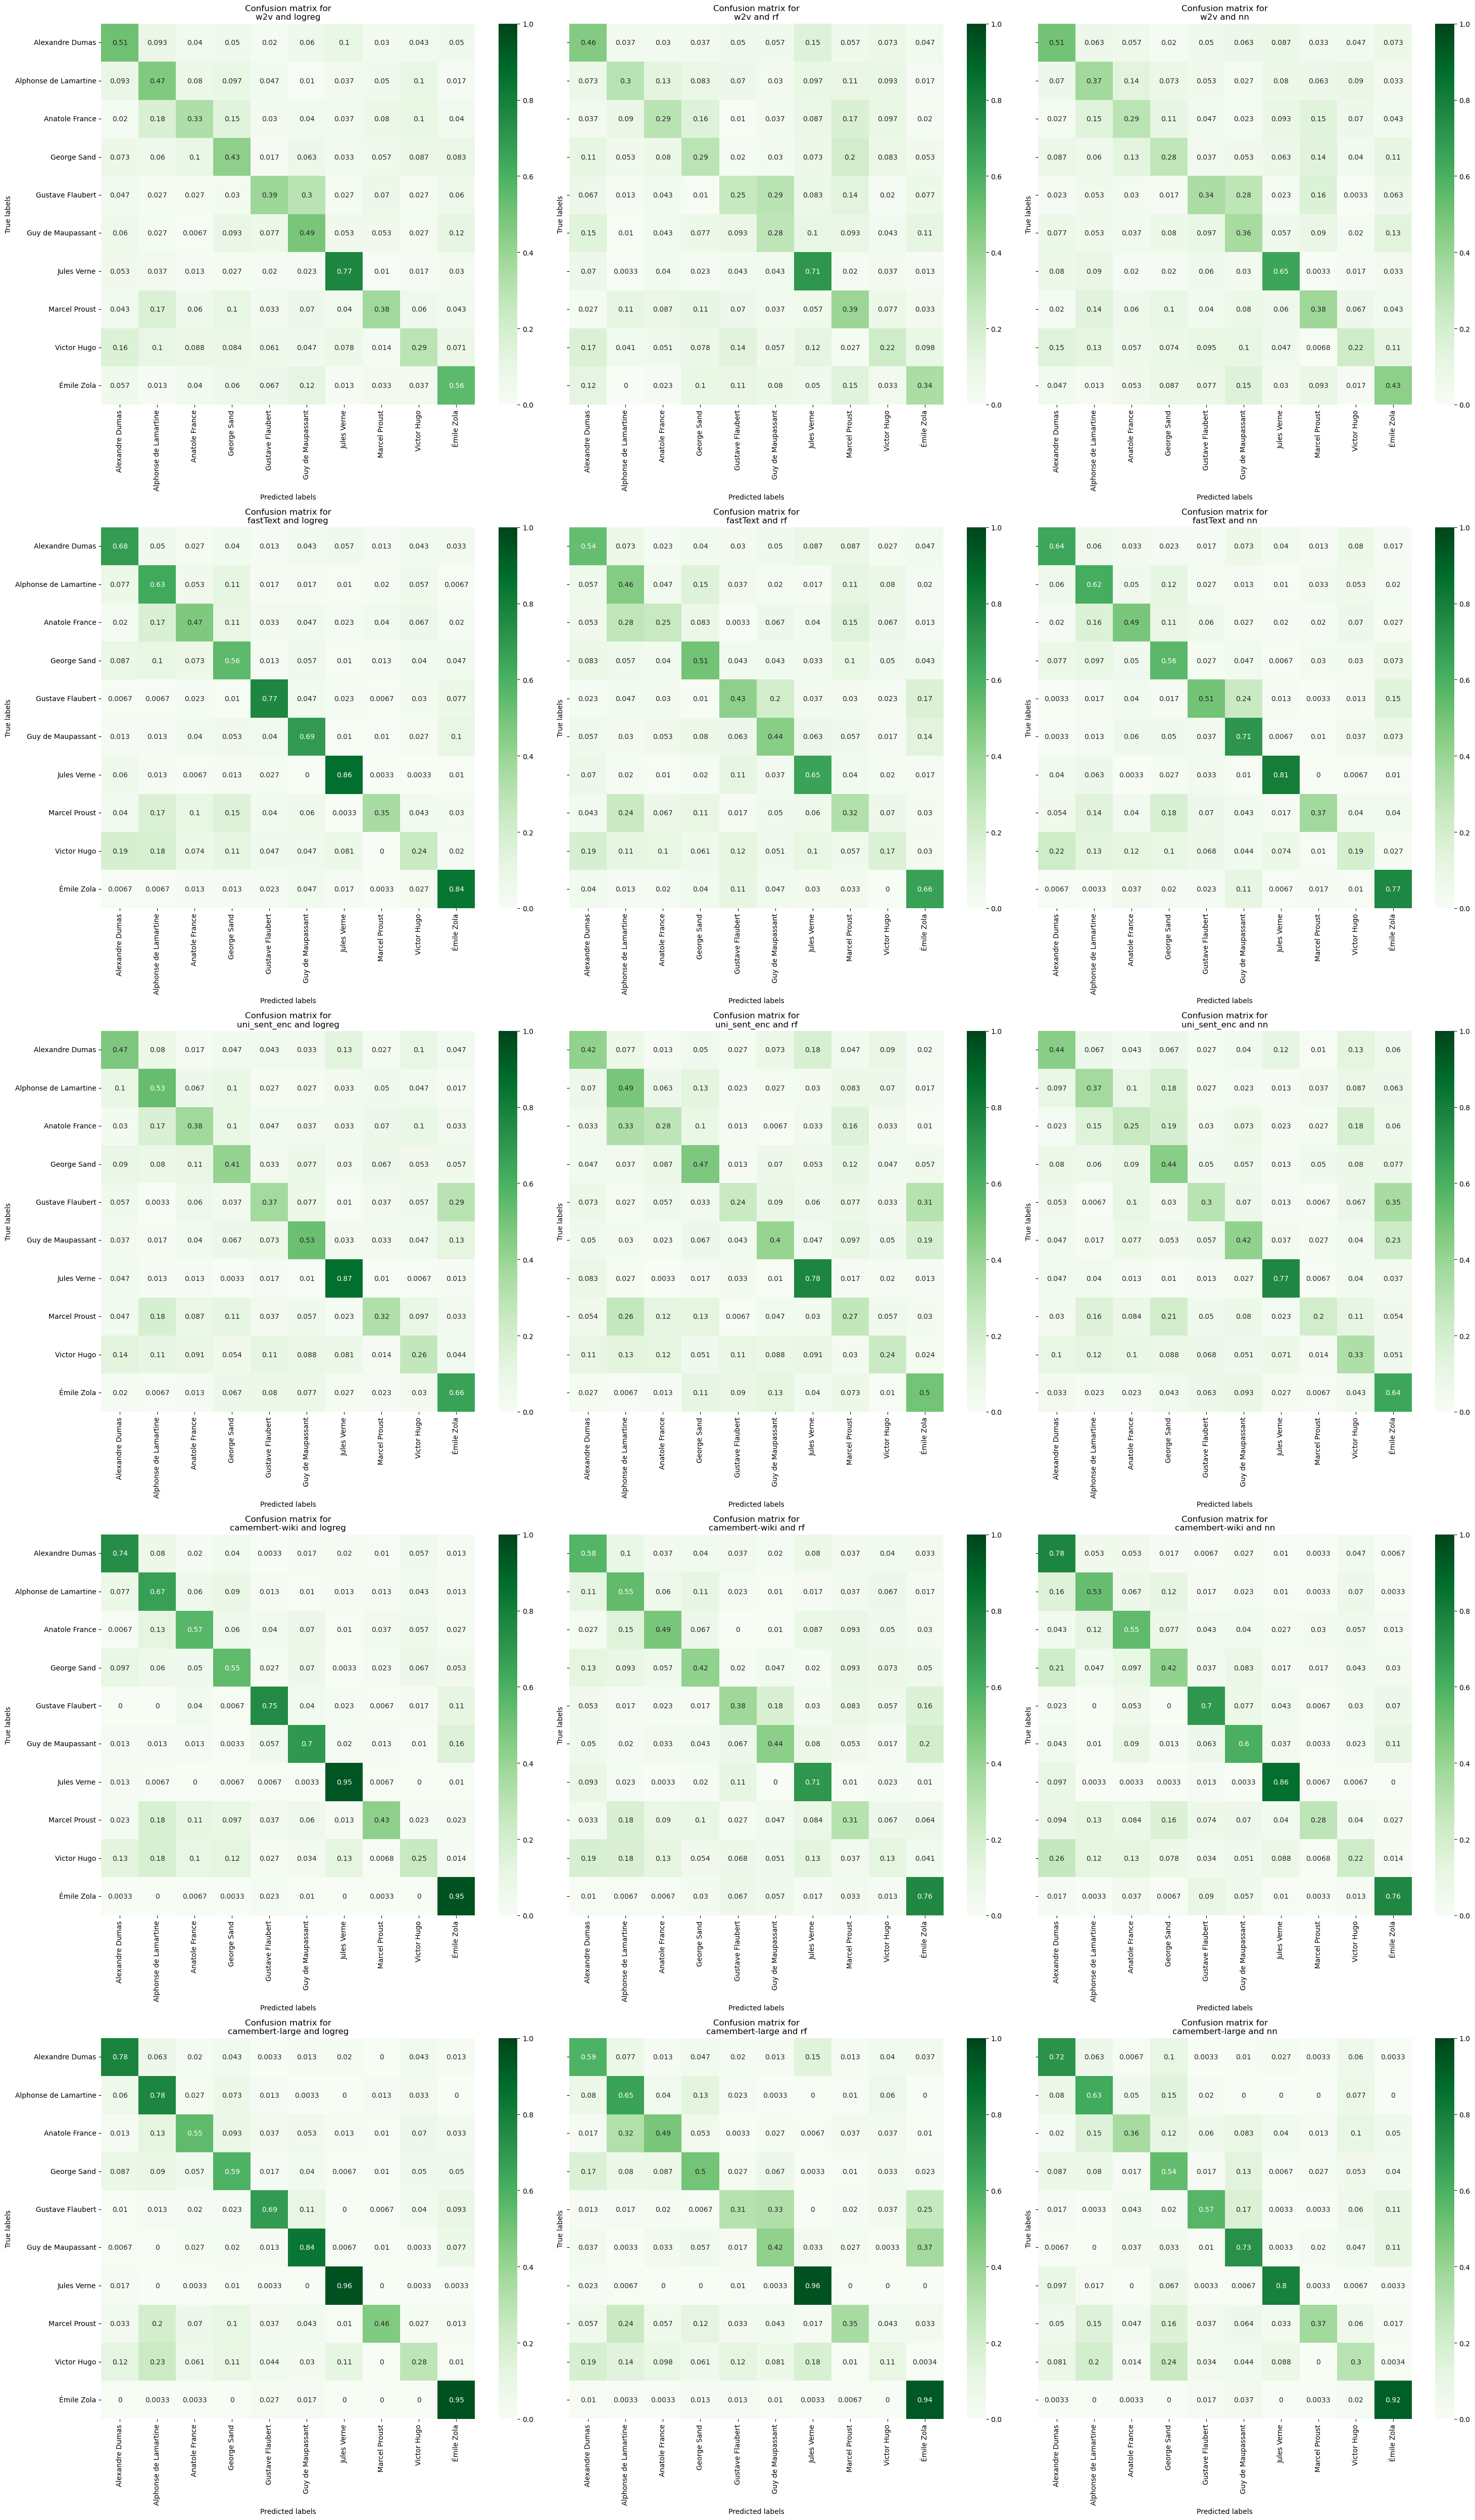

In [15]:

from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
cm={}
class_report={}
fig, axs = plt.subplots(5,3, sharey=True, figsize=(30, 50))
for j, emb in enumerate(emb_models):
    cm[emb]={}
    class_report[emb]={}
    for i, method in enumerate(['logreg', 'rf', 'nn']):
        if method=='nn':
            X_=X_test_preprocessed[emb]
        else:
            X_=X[emb]["test"]
        
        cm[emb][method]=confusion_matrix(y[emb]["test"], best_model[emb][method].predict(X_), normalize='true')
        class_report_=classification_report(y[emb]["test"], best_model[emb][method].predict(X_), output_dict=True)
        class_report[emb][method]=pd.DataFrame(class_report_).transpose() #from here:https://stackoverflow.com/questions/39662398/scikit-learn-output-metrics-classification-report-into-csv-tab-delimited-format
        
        print('Accuracy for {} and {}: {}'.format(emb, method, class_report[emb][method].loc['accuracy', 'precision']))
        class_report[emb][method].drop('accuracy', axis=0, inplace=True) #it is already in results_df
        print('Further scores for {} and {}:'.format(emb, method))
        display(class_report[emb][method])
        
        sns.heatmap(cm[emb][method], 
                    xticklabels=best_model[emb][method].classes_, 
                    yticklabels=best_model[emb][method].classes_, 
                    annot=True, 
                    vmin=0, vmax=1,
                    cmap='Greens', ax=axs[j, i])
        axs[j, i].set_xlabel('Predicted labels')
        axs[j, i].set_ylabel('True labels')

        axs[j, i].set_title('Confusion matrix for\n{} and {}'.format(emb, method))
    

plt.tight_layout()

plt.show()

For a large majority of the embedding-method combinations, Verne and Zola are the easiest and Proust and Hugo are the hardest to recognise for our models:

In [16]:
from collections import Counter
def hardest_easiest(score, n):
    counts_hardest_n=Counter()
    counts_easiest_n=Counter()
    for emb in emb_models:
        for method in ['logreg', 'rf', 'nn']:
            counts_hardest_n.update(Counter(class_report[emb][method][score].sort_values().head(n).index))
            counts_easiest_n.update(Counter(class_report[emb][method][score].sort_values(ascending=False).head(n).index))
            
    print('Considering all embedding-method combinations, number of times an author was among the {} with the lowest {}: {}'.format(n, score, counts_hardest_n.most_common()))
    print('Number of times an author was among the {} with the highest {}: {}'.format(n, score, counts_easiest_n.most_common()))
    return counts_hardest_n.most_common(), counts_easiest_n.most_common()
                          
                          

In [17]:
hardest_easiest('f1-score', 2);

Considering all embedding-method combinations, number of times an author was among the 2 with the lowest f1-score: [('Victor Hugo', 14), ('Marcel Proust', 8), ('Anatole France', 3), ('George Sand', 3), ('Gustave Flaubert', 2)]
Number of times an author was among the 2 with the highest f1-score: [('Jules Verne', 15), ('Émile Zola', 13), ('Alexandre Dumas', 2)]


In Proust's case, this is understandable as the only way to create create the book bundles was to include <i>In search of lost time</i> in the training book bundle. The two small books from which we chose our test set are completely different (they contain prose poems, novellas, prefaces, press articles).

Interestingly, Proust's texts seemed to be very different when we did classical text analysis: they had long sentences, very long paragraphs, lot of adverbs. If we assume this could generalize for a "new manuscript", we could add these parameters in a next iteration of our classifier.

Let's put the macro-averaged precision, recall and f1 scores in dataframes and visualize them.

precision


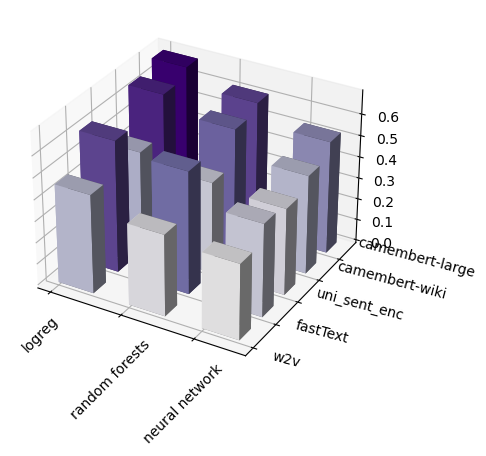

recall


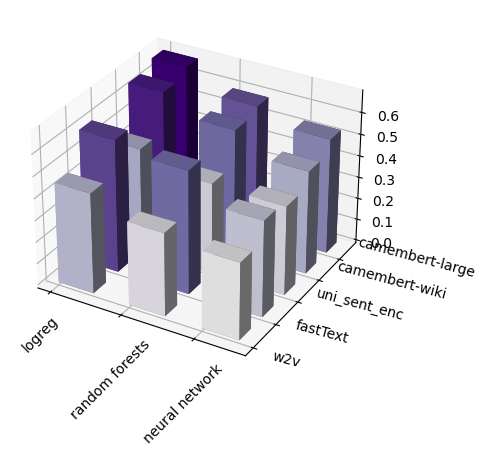

f1-score


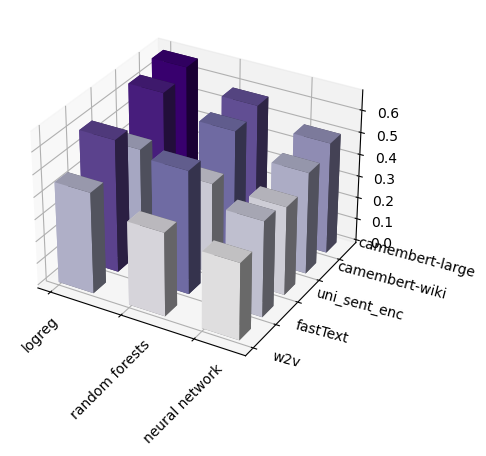

In [18]:

scores_df={}
long_names=['logreg', 'random forests', 'neural network']
for score in ['precision', 'recall', 'f1-score']:
    scores_df[score]=pd.DataFrame()
    for emb in emb_models:
        for i, method in enumerate(['logreg', 'nn', 'rf']):
            scores_df[score].loc[emb, long_names[i]]=class_report[emb][method].loc['macro avg', score]
    print(score)        
    threed_bar(scores_df[score])



Changing the evaluation metric to these scores would not change our conclusions at all.

## Error analysis of the best method-embedding pair

From now on we will analyze the best method-embedding combination: camembert-large and logistic regression.

Let's create a dataframe about which test chunks by an author are classified to a given author. The true authors are the rows, and the columns are the predicted authors and 'uncorrect' for all the mislabeled chunks. Based on this, let's define a function for listing the chunks themselves.

In [19]:
authors=list(no_dupl['author'].unique())
class_df=pd.DataFrame(index=authors, columns=authors+['uncorrect'])
class_df = class_df.applymap(lambda x: [])
pred_labels=best_model[best_emb]['logreg'].predict(X[best_emb]["test"])
for i, true_label in enumerate(y[best_emb]["test"]):
    real_index=shuffled_indeces[best_emb]['test'][i]
    class_df.loc[true_label, pred_labels[i]].append(real_index) #we reverse the shuffle operation
for true_author in authors:
    class_df.loc[true_author, 'uncorrect']=[]
    for predicted_author in authors:
        if true_author!=predicted_author:
            class_df.loc[true_author, 'uncorrect']+=class_df.loc[true_author, predicted_author]
class_df

George Sand  \
George Sand            [263, 104, 22, 156, 118, 117, 224, 33, 138, 25...   
Émile Zola                                                            []   
Alphonse de Lamartine  [638, 720, 641, 783, 701, 619, 731, 700, 713, ...   
Anatole France         [1109, 1127, 982, 1013, 921, 943, 1065, 1027, ...   
Jules Verne                                           [1491, 1362, 1271]   
Victor Hugo            [1768, 1564, 1509, 1646, 1758, 1749, 1626, 152...   
Guy de Maupassant                   [1969, 2085, 2062, 1863, 1913, 1940]   
Alexandre Dumas        [2175, 2382, 2183, 2179, 2224, 2223, 2106, 229...   
Marcel Proust          [2687, 2621, 2596, 2504, 2458, 2512, 2437, 261...   
Gustave Flaubert              [2946, 2797, 2894, 2790, 2928, 2775, 2745]   

                                                              Émile Zola  \
George Sand            [253, 298, 276, 235, 49, 242, 188, 232, 162, 2...   
Émile Zola             [480, 305, 567, 514, 317, 385, 496, 482, 399, ...   
Alphonse de Lamartine                                                 []   
Anatole France         [1043, 1056, 986, 1067, 1082, 1021, 1128, 1035...   
Jules Verne                                                       [1471]   
Victor Hugo                                           [1658, 1548, 1557]   
Guy de Maupassant      [1906, 1988, 2025, 1923, 1939, 2090, 2088, 190...   
Alexandre Dumas                                 [2114, 2340, 2301, 2315]   
Marcel Proust                                   [2581, 2493, 2553, 2645]   
Gustave Flaubert       [2853, 2816, 2759, 2829, 2860, 2964, 2764, 280...   

                                                   Alphonse de Lamartine  \
George Sand            [23, 227, 15, 228, 290, 271, 52, 87, 158, 139,...   
Émile Zola                                                         [493]   
Alphonse de Lamartine  [812, 615, 817, 601, 686, 654, 779, 849, 890, ...   
Anatole France         [1049, 914, 912, 918, 1083, 997, 991, 1042, 11...   
Jules Verne                                                           []   
Victor Hugo            [1633, 1521, 1554, 1588, 1762, 1788, 1725, 161...   
Guy de Maupassant                                                     []   
Alexandre Dumas        [2211, 2123, 2348, 2359, 2267, 2289, 2151, 228...   
Marcel Proust          [2529, 2547, 2658, 2552, 2474, 2539, 2441, 254...   
Gustave Flaubert                                [2832, 2881, 2825, 2897]   

                                                          Anatole France  \
George Sand            [113, 189, 267, 19, 73, 68, 265, 8, 131, 230, ...   
Émile Zola                                                         [396]   
Alphonse de Lamartine           [878, 898, 785, 679, 699, 873, 816, 659]   
Anatole France         [944, 910, 1023, 1122, 1099, 1047, 1098, 989, ...   
Jules Verne                                                       [1388]   
Victor Hugo            [1737, 1519, 1686, 1765, 1746, 1570, 1602, 159...   
Guy de Maupassant       [1917, 1893, 2018, 1900, 1984, 1996, 1986, 1834]   
Alexandre Dumas                     [2228, 2281, 2372, 2231, 2145, 2127]   
Marcel Proust          [2464, 2520, 2571, 2616, 2451, 2688, 2487, 261...   
Gustave Flaubert                    [2936, 2933, 2932, 2846, 2803, 2727]   

                                                             Jules Verne  \
George Sand                                                    [88, 216]   
Émile Zola                                                            []   
Alphonse de Lamartine                                                 []   
Anatole France                                   [1005, 1039, 902, 1179]   
Jules Verne            [1300, 1357, 1231, 1387, 1373, 1267, 1464, 139...   
Victor Hugo            [1764, 1528, 1779, 1761, 1691, 1625, 1505, 154...   
Guy de Maupassant                                           [2032, 2040]   
Alexandre Dumas                     [2350, 2365, 2109, 2325, 2284, 2391]   
Marcel Proust                

In [20]:
def misclassified_chunks(true_author, predicted_author):
    idx_list=class_df.loc[true_author, predicted_author]
    chunks=[all_chunks['test'][i] for i in idx_list]
    numbers=[all_chunk_numbers['test'][i] for i in idx_list]
    return chunks, numbers


Let's try it for Victor Hugo. His chunks are most often misclassified as Lamartine. Let's compare some of those chunks with some rightly classified ones.

In [21]:
print('Victor Hugo classified as Victor Hugo\n\n')
chs_r, ns_r= misclassified_chunks('Victor Hugo', 'Victor Hugo')
for i, ch in enumerate(chs_r[:5]):
    print('{}\n({})\n'.format(ch, no_dupl.loc[ns_r[i], 'title']))
print('\n\n\n\nAs Lamartine\n\n')    
chs_w, ns_w= misclassified_chunks('Victor Hugo', 'Alphonse de Lamartine')
for i, ch in enumerate(chs_w[:5]):
    print('{}\n({})\n'.format(ch, no_dupl.loc[ns_w[i], 'title']))



Victor Hugo classified as Victor Hugo


Car la colère chez les femmes est comme la pluie dans la forêt; elle tombe deux fois. Bis pluit. Le soir Pécopin arrivait poudreux et fatigué. Bauldour boudait et murmurait un peu avec une larme dans le coin de son oeil bleu. Mais Pécopin baisait sa petite main, et elle se taisait; Pécopin baisait son beau front, et elle souriait. Le front de Bauldour était blanc, pur et admirable comme la trompe d'ivoire du roi Charlemagne. Puis elle se retirait dans sa tourelle et Pécopin dans la sienne. Elle ne souffrait jamais que ce chevalier lui prît la ceinture. Un soir il lui pressa légèrement le coude, et elle rougit très-fort. Elle était fiancée et non mariée. Pudeur est à la femme ce que chevalerie est à l'homme.  II L'oiseau Phénix et la planète Vénus. Ils s'adoraient à faire envie. Pécopin avait dans sa halle d'armes à Sonneck une grande peinture dorée représentant le ciel et les neuf cieux, chaque planète avec sa couleur propre et son nom écrit en v

It is hard to see anything off with these misclassified chunks. Let's try to do it in a more methodical way.

## Analysis of the misclassified chunks

We can start the analysis at the book level. Which books are the hardest to classify per author? We calculate the number of misclassified chunks per book and then normalize them with the chunk length of the book (this is necessary because we chose a random sample from the concatenation of all chunks in a book bundle, i.e the probability that a chunk comes from a given book in the bundle is proportional to the book's chunk length).

In [22]:
from collections import Counter
def misclassified_distribution(author):
    chs, ns= misclassified_chunks(author, 'uncorrect')
    return Counter({no_dupl.loc[book_number, 'title']:count/no_dupl.loc[book_number, 'chunk_numbers'] for book_number, count in Counter(ns).items()}).most_common()
misclassified_distribution('Victor Hugo')

[("Han d'Islande", 0.22580645161290322),
 ('Le Rhin, Tome IV', 0.16666666666666666),
 ('Le Rhin, Tome I', 0.14953271028037382),
 ('Le Rhin, Tome II', 0.136986301369863),
 ('Le Rhin, Tome III', 0.12195121951219512)]

This may be because Han d'Islande is an early work. If we had better data about the dates, we could try to do more granular text analysis according to when an author wrote a text.

Let's check the misclassification distribution for all authors:

In [23]:
for author in no_dupl['author'].unique():
    print('\033[1;4m'+author+'\033[0m' )
    print(misclassified_distribution(author))

George Sand
[('Correspondance, 1812-1876 — Tome 4', 0.05405405405405406), ('Correspondance, 1812-1876 — Tome 5', 0.042071197411003236), ('Correspondance, 1812-1876 — Tome 1', 0.0392156862745098), ("Lettres d'un voyageur", 0.037209302325581395), ('Correspondance, 1812-1876 — Tome 2', 0.034055727554179564), ("Nouvelles lettres d'un voyageur", 0.0319634703196347), ("Francia; Un bienfait n'est jamais perdu", 0.029940119760479042), ('Les beaux messieurs de Bois-Doré', 0.023474178403755867), ('Le péché de Monsieur Antoine, Tome 2', 0.022099447513812154), ('Le péché de Monsieur Antoine, Tome 1', 0.0169971671388102), ('Valentine', 0.016853932584269662), ('Jacques', 0.014925373134328358), ('Correspondance, 1812-1876 — Tome 3', 0.012539184952978056), ('Simon', 0.005128205128205128)]
Émile Zola
[('Le Rêve', 0.01953125), ('Germinal', 0.007716049382716049), ('Nana', 0.005357142857142857), ('Le Docteur Pascal', 0.004424778761061947)]
Alphonse de Lamartine
[('Cours familier de Littérature - Volume 17

For most authors, it is hard to draw consequences. However, for George Sand, it seems that the classifier has more trouble with the correspondence than the other (mostly fictional) works, which makes sense.

We can now can compare the set of rightly classified and wrongly classified chunks as we analysed the whole books when we explored the data.
For example, we can then take a closer look at the character level and try to see where the distribution of characters differs:

In [24]:

def counts(author):
    counts_right=Counter()
    chunks, _=misclassified_chunks(author, author)
    for chunk in chunks:
        counts_right.update(Counter(chunk))
    all_chars_right=sum(counts_right.values())
    counts_wrong=Counter()
    chunks, _=misclassified_chunks(author, 'uncorrect')
    for chunk in chunks:
        counts_wrong.update(Counter(chunk))
    all_chars_wrong=sum(counts_wrong.values())
    chars=list(set(counts_right.keys())|set(counts_wrong.keys()))
    return counts_right, counts_wrong, all_chars_right, all_chars_wrong, chars

In [25]:
def llr(k1, N1, k2, N2):
    k1=k1+1
    k2=k2+1
    E1 = (k1+k2)*(N1/(N1+N2))
    E2 = (k1+k2)*(N2/(N1+N2))
    LLR = 2*(k1*np.log(k1/E1)+k2*np.log(k2/E2))
    return LLR

In [26]:
def high_llr(author, n):
    counts_right, counts_wrong, all_chars_right, all_chars_wrong, chars=counts(author)
    llr_df=pd.DataFrame(columns=['llr_value', 'higher_freq_in_right'], index=chars)
    for char in chars:
        llr_df.loc[char, 'llr_value']=llr(counts_right[char], all_chars_right, counts_wrong[char], all_chars_wrong)
        if counts_right[char]/all_chars_right>counts_wrong[char]/all_chars_wrong:
            llr_df.loc[char, 'higher_freq_in_right']=True
        else:
            llr_df.loc[char, 'higher_freq_in_right']=False
    high_llr_more_in_right=llr_df[llr_df['higher_freq_in_right']==True].sort_values('llr_value', ascending=False).head(n).index
    high_llr_more_in_wrong=llr_df[llr_df['higher_freq_in_right']==False].sort_values('llr_value', ascending=False).head(n).index
    
    return llr_df, high_llr_more_in_right, high_llr_more_in_wrong
    
llr_df_hugo, high_llr_more_in_right_hugo, high_llr_more_in_wrong_hugo=high_llr('Victor Hugo', 20)
print('Characters with a frequency difference, higher frequency in the right classifications:', ', '.join(list(high_llr_more_in_right_hugo)))
print('Characters with a frequency difference, higher frequency in the wrong classifications:', ', '.join(list(high_llr_more_in_wrong_hugo)))

Characters with a frequency difference, higher frequency in the right classifications: 1, 2, 4, ., R, F, 8, X, 7, L, E, P, U, D, 5, 3, I, è, 6, C
Characters with a frequency difference, higher frequency in the wrong classifications: v, É, d, K, n, ,, ü, k, ', ô, m,  , j, ë, r, a, é, x, À, Z


As we saw in the data exploration section, we can use the differences in character distribution to find formatting differences and sometimes also to guess the genre (plays have a high frequency of capital letters, academic notes have a high frequency of numbers) and then we can determine whether these aspects hinder our classifier. 

In this case we can see that the classifier works better when there are a lot of numbers in the chunk. Let's have a look at the chunks with a high number of these high llr characters first and a high number of digits second:

In [27]:
def displaychunks(true_author, predicted_author, chars, n):
        chunks, numbers=misclassified_chunks(true_author, predicted_author)
        counts=[sum([Counter(chunk)[char] for char in chars]) for chunk in chunks]
        return Counter({(chunk, no_dupl.loc[number, 'title']):count for chunk, number, count in zip(chunks, numbers, counts)}).most_common(n)

In [28]:
displaychunks('Victor Hugo', 'Victor Hugo', high_llr_more_in_right_hugo, 5)

[(("LETTRE XIV LE RHIN. Diverses déclarations d'amour à différentes choses de la création.-L'auteur cite Boileau.-Groupe de tous les fleuves.-Histoire.-Les volcans.-Les Celtes.-Les Romains.-Les colonies romaines.-Quelles ruines il y avait sur le Rhin il y a douze cents ans.-Charlemagne.-Fin du Rhin historique.-Commencement du Rhin fabuleux.-Mythologie gothique.-Fourmillement des légendes.-Le hideux et le charmant mêlés sous mille formes dans une lueur fantastique.-Dénombrement des figures chimériques.-Les fables pâlissent; le jour se fait; l'histoire reparaît.-Ce que font quatre hommes assis sur une pierre.-Rhens.-Triple naissance de trois grandes choses presque au même lieu et au même moment.-Le Rhin religieux et militaire.-Les princes ecclésiastiques composés des mêmes éléments que le pape.-Qui se développe empiète.-Les comtes palatins protestent par le moyen des comtesses palatines.-Etablissements des ordres de chevalerie.-Naissances des villes marchandes.-Brigands gigantesques du R

In [29]:
displaychunks('Victor Hugo', 'Victor Hugo', '0123456789', 5)

[(("deux au treizième; Furstemberg par les palatins, et Rheinfels, en 1219, par Thierry III, comte de Katzenellenbogen; quatre au quatorzième: Vogtsberg, en 1340, par un Falkenstein; Fursteneck, en 1348, par l'archevêque Henri III; le Chat, en 1383, par le comte de Katzenellenbogen; et la Souris, dix ans après, par un Falkenstein. Un seulement date du seizième siècle: Philipsburg, bâti, de 1568 à 1571, par le landgrave Philippe le Jeune. Quatre de ces citadelles, toutes les quatre sur la rive gauche, chose remarquable, Brichenstein, Rheinstein, Falkenburg et Sonneck, ont été détruites en 1282 par Rodolphe de Habsbourg; une, le Rolandseck, par l'empereur Henri V; cinq par Louis XIV, en 1689, Fursteneck, Stahleck, Schoenberg, Stolzenfels et Hammerstein; une par Napoléon, le Rheinfels; une par un incendie, Rheineck; et une par la bande -noire, Gutenfels. On ne sait qui a construit Reichenstein, Rheinstein, Falkenburg, Stolzenfels, Rheineck et Markusburg, restauré en 1644 par Jean le Batai

It is possible that the training set contained a lot of dates in the chunks by Hugo and thus our classifier has less trouble recognising chunks with a lot of dates in the test set. I do not see an obvious way to remedy this. 

After the character analysis, we can examine the rightly and wrongly classified chunks at higher levels: are the word, word length, sentence length, pos distributions different in the two sets? This is beyond the scope of this project.

### How would the accuracy change in the "lazy student" case?

What would happen if we did not make sure that the training set and the test set come from different books? I.e. if we allowed our classifier to recognize the author of chunks coming from the same books that it was trained on, like a lazy student who read only 80% of the bibliography and has to recognise a chunk he hasn't seen but he might have read chunks from the same book?

Let's just recreate test and train sets by shuffling them all, do a logistic regression with the best hyperparameter we found, and plot the confusion matrix.

In [30]:

X_all = np.vstack([X[best_emb]["valid1"], X[best_emb]["valid2"], 
                       X[best_emb]["valid3"], X[best_emb]["valid4"], X[best_emb]["test"]])
y_all = np.hstack([y[best_emb]["valid1"], y[best_emb]["valid2"], 
                       y[best_emb]["valid3"], y[best_emb]["valid4"], y[best_emb]["test"]])

from sklearn.model_selection import train_test_split


X_tr, X_te, y_tr, y_te = train_test_split(X_all, y_all, test_size=0.2, random_state=0)
logreg=LogisticRegression(solver='liblinear', C=0.1)
logreg.fit(X_tr, y_tr)
logreg.score(X_te, y_te)

0.7839279759919974

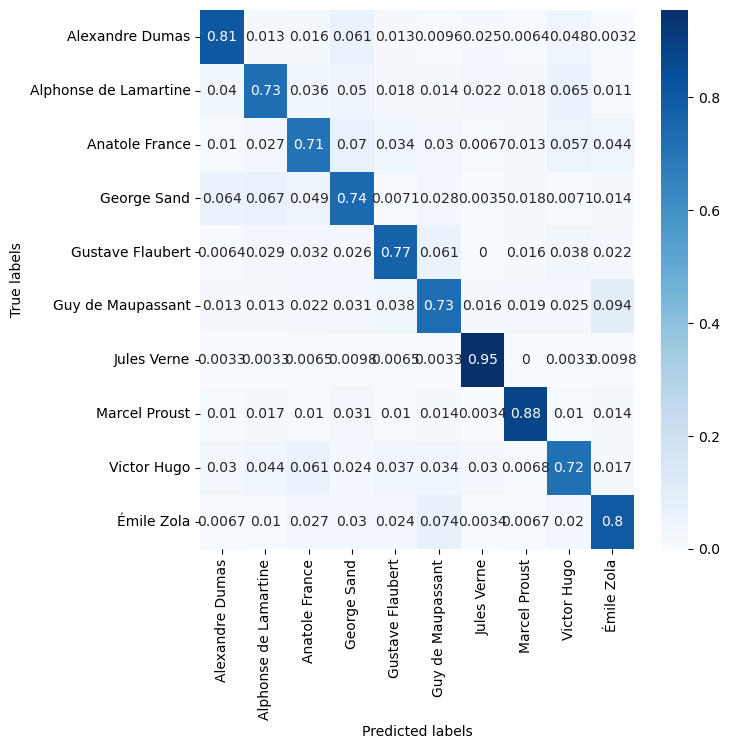

In [31]:
cm['lazy'] = confusion_matrix(y_te, logreg.predict(X_te), normalize='true')
plt.figure(figsize=(7, 7))
sns.heatmap(cm['lazy'], 
            xticklabels=logreg.classes_, 
            yticklabels=logreg.classes_, 
            annot=True, 
            cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

We would get a higher score (see e.g. Hugo and Proust) but we should doubt that this score would generalise if we wanted to use our model to predict the author of texts that are coming from entirely new books (i.e in the 'new manuscript' setting).

Let's save the best model we have:

In [32]:
import pickle
pickle.dump(best_model[best_emb]['logreg'], open('logreg_model.sav', 'wb'))

## Further improvement

There are a number of ways we could improve our results. We can 
<ul>
    <li>further analyse the <b>anomalies found in the data exploration phase</b> (e.g. too short sentences) and the <b>misclassified chunks</b> and improve the preprocessing based on this; this could lead to better performance but also less cheating in the form of formatting recognition, which is good for generalizability but may lower the measured accuracy</li>
    <li>try <b>other classification algorithms</b></li>
    <li>improve the <b>architecture of our neural network</b> which is quite simple</li>
    <li>use <b>ensemble</b> learning by combining more models</li>
    <li>use even <b>bigger embeddings</b>, such as cedille or ada</li>
    <li>use the the <b>vectors for each word</b>, or a selection of them (the most relevant words selected by e.g. tfidf), not only the vectors for the whole chunks</li>
    <li>include <b>classical text analysis results as input</b> to our model</li>    
    <li><b>finetune</b> a model on our training set instead of using its embeddings out of the box</li>
</ul>

## Lessons

<b>About literature<b>

We discovered that Anatole France reused parts of "Monsieur Bergeret" in his "Opinions sociales" and that Proust is an outlier in a lot of respects at the character/POS level.

<b>About text data and NLP<b>

Sometimes the easiest task is the hardest. We couldn't find a way to determine where the books start and had to resort to cutting a huge part. Splitting a text to sentences was far from perfect even though spacy is a quite sophisticated and recent tool. Tokenizing sentences and words sometimes did not work because of seemingly trivial issues, such as the use of em-dashes or underscores. Analysing texts and mistokenizations at the character level and improving the preprocessing is a lot of work but helped and could help more.
    
<b>About machine learning<b>
    
Generating train and test sets and making sure they are truly seperate is not trivial. Both finding the duplicates and finding the books that belong together required some effort.
Also, the "new manuscript" challenge is much harder than the "lazy student" one. 